In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


In [11]:
import gc 
gc.collect()

0

# Funciones auxiliares

In [3]:
import matplotlib.pyplot as plt

def plot_feature_importance_bar(model, feature_names, top_n=15):
    importances = model.feature_importances_
    sorted_idx = importances.argsort()[::-1][:top_n]
    
    plt.figure(figsize=(10, 6))
    plt.barh(
        range(top_n),
        importances[sorted_idx][::-1],
        align='center'
    )
    plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx][::-1])
    plt.xlabel("Importancia")
    plt.title(f"Top {top_n} características más importantes")
    plt.tight_layout()
    plt.show()

def plot_real_vs_pred(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label="Predicciones", color="navy", edgecolors="k")
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Línea perfecta")
    plt.xlabel("Valor real (N_arribos_intervalo)")
    plt.ylabel("Valor predicho")
    plt.title("Comparación entre predicción y realidad")
    plt.legend()
    plt.tight_layout()
    plt.show()

def print_features_usadas(features):
    print(f"\n🧠 El modelo está usando {len(features)} features:")
    for i, f in enumerate(features, 1):
        print(f"{i:2d}. {f}")

def print_ejemplos_val(y_val, y_pred, n=5):
    print("\nEjemplos de validación:")
    ejemplos = pd.DataFrame({
        "Real": y_val.values,
        "Predicho (round)": y_pred
    }).reset_index(drop=True).head(n)
    print(ejemplos.to_string(index=False))

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from tqdm import tqdm

def entrenar_xgboost_por_finde(path_modelado):
    df = pd.read_parquet(path_modelado)
    df.dropna(inplace=True)

    target = "N_arribos_intervalo"
    cols_a_excluir = [
    "N_arribos_intervalo",  
    "N_salidas_intervalo",
    "fecha_intervalo",
    "id_recorrido",
    "id_usuario",
    "fecha_origen",
    "estacion_destino_viejo_us_lag1",
    "estacion_destino_viejo_us_lag2",
    "estacion_destino_viejo_us_lag3",
    "estacion_origen_viejo_us_lag1",
    "estacion_origen_viejo_us_lag2",
    "estacion_origen_viejo_us_lag3",
    "arribos_lag1",
    "arribos_lag2",
    "arribos_lag3",
    "salidas_lag1",
    "salidas_lag2",
    "arribos_rolling7",     
    "duracion_recorrido",  
    "ultima_estacion_origen_usuario",
    "ultima_estacion_destino_usuario",
    "tiempo_desde_ultimo_viaje_usuario",
    "barrio_ultima_estacion_origen_usuario",
    "barrio_ultima_estacion_destino_usuario",
    "estacion_origen_viejo_us",
    "estacion_destino_viejo_us"
    ]

    df_train = df[(df["año_intervalo"] < 2024) | ((df["año_intervalo"] == 2024) & (df["mes_intervalo"] <= 4))]
    df_val = df[(df["año_intervalo"] == 2024) & (df["mes_intervalo"].between(5, 8))]

    y_val_preds_global = pd.Series(index=df_val.index, dtype=float)

    for es_finde_val in tqdm([0, 1], desc="Entrenando por es_finde"):
        print(f"\n=== XGBoost - es_finde = {es_finde_val} ===")
        train_sub = df_train[df_train["es_finde"] == es_finde_val]
        val_sub = df_val[df_val["es_finde"] == es_finde_val]

        X_train = train_sub.drop(columns=cols_a_excluir)
        y_train = train_sub[target]
        X_val = val_sub.drop(columns=cols_a_excluir)
        y_val = val_sub[target]


        print_features_usadas(X_train.columns)

        modelo = XGBRegressor(
            n_estimators=500,
            max_depth=10,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="count:poisson",
            tree_method="hist",         
            random_state=42,
            n_jobs=-1
)
        modelo.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        y_pred = modelo.predict(X_val)
        y_val_preds_global.loc[val_sub.index] = y_pred

        print(f"[Train] MAE: {mean_absolute_error(y_train, modelo.predict(X_train)):.4f} | R²: {r2_score(y_train, modelo.predict(X_train)):.4f}")
        print(f"[Val]   MAE: {mean_absolute_error(y_val, y_pred):.4f} | R²: {r2_score(y_val, y_pred):.4f}")
        plot_feature_importance_bar(modelo, X_train.columns)
        plot_real_vs_pred(y_val, y_pred)
        print_ejemplos_val(y_val, y_pred)

    print("\n=== XGBoost - MÉTRICAS GLOBALES ===")
    y_val_true = df_val[target]
    print(f"MAE Global: {mean_absolute_error(y_val_true, y_val_preds_global):.4f}")
    print(f"R² Global:  {r2_score(y_val_true, y_val_preds_global):.4f}")

🔍 Entrenando modelo con XGBoost Poisson...


Entrenando por es_finde:   0%|          | 0/2 [00:00<?, ?it/s]


=== XGBoost - es_finde = 0 ===

🧠 El modelo está usando 28 features:
 1. id_estacion_origen
 2. modelo_bicicleta
 3. barrio_origen
 4. dia_semana
 5. es_finde
 6. estacion_del_anio
 7. edad_usuario
 8. año_alta
 9. mes_alta
10. genero_FEMALE
11. genero_MALE
12. genero_OTHER
13. usuario_registrado
14. zona_origen_cluster
15. cantidad_estaciones_cercanas_origen
16. año_origen
17. mes_origen
18. dia_origen
19. hora_origen
20. minuto_origen
21. segundo_origen
22. año_intervalo
23. mes_intervalo
24. dia_intervalo
25. hora_intervalo
26. minuto_intervalo
27. dist_ciclovia_m
28. ciclo_len_200m
[Train] MAE: 1.4426 | R²: 0.2992
[Val]   MAE: 1.9442 | R²: -0.0197


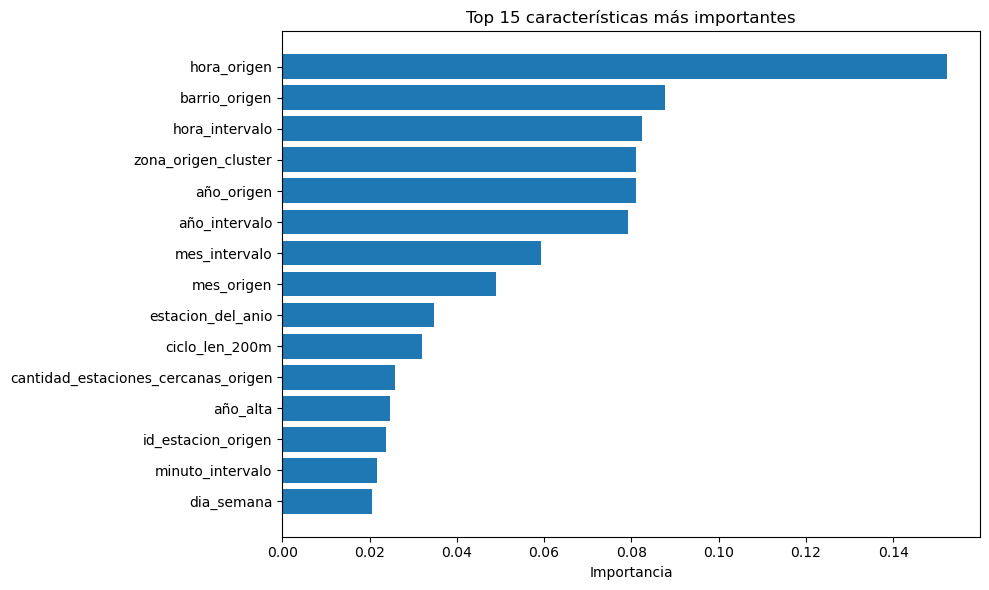

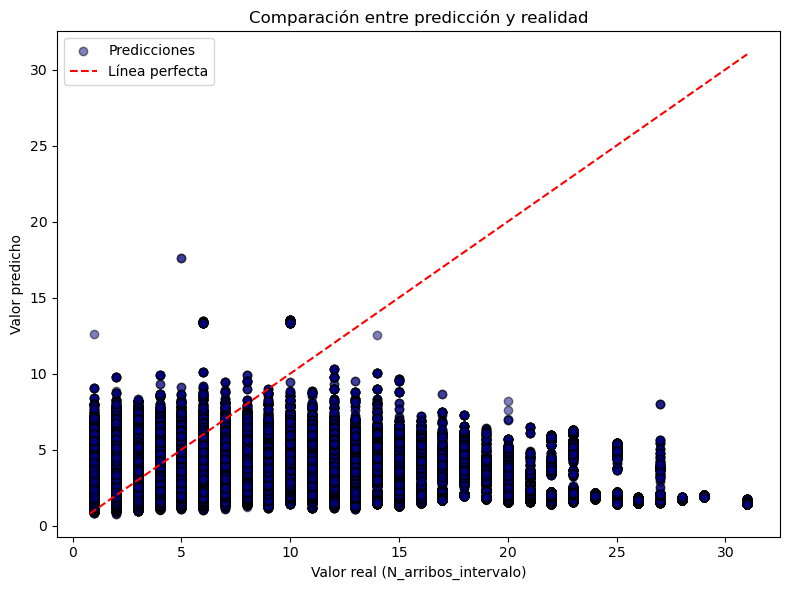

Entrenando por es_finde:  50%|█████     | 1/2 [06:42<06:42, 402.04s/it]


Ejemplos de validación:
 Real  Predicho (round)
    3          2.638976
    3          2.638976
    3          2.638976
    3          2.638976
    3          2.638976

=== XGBoost - es_finde = 1 ===

🧠 El modelo está usando 28 features:
 1. id_estacion_origen
 2. modelo_bicicleta
 3. barrio_origen
 4. dia_semana
 5. es_finde
 6. estacion_del_anio
 7. edad_usuario
 8. año_alta
 9. mes_alta
10. genero_FEMALE
11. genero_MALE
12. genero_OTHER
13. usuario_registrado
14. zona_origen_cluster
15. cantidad_estaciones_cercanas_origen
16. año_origen
17. mes_origen
18. dia_origen
19. hora_origen
20. minuto_origen
21. segundo_origen
22. año_intervalo
23. mes_intervalo
24. dia_intervalo
25. hora_intervalo
26. minuto_intervalo
27. dist_ciclovia_m
28. ciclo_len_200m
[Train] MAE: 1.7261 | R²: 0.5706
[Val]   MAE: 1.5850 | R²: 0.1174


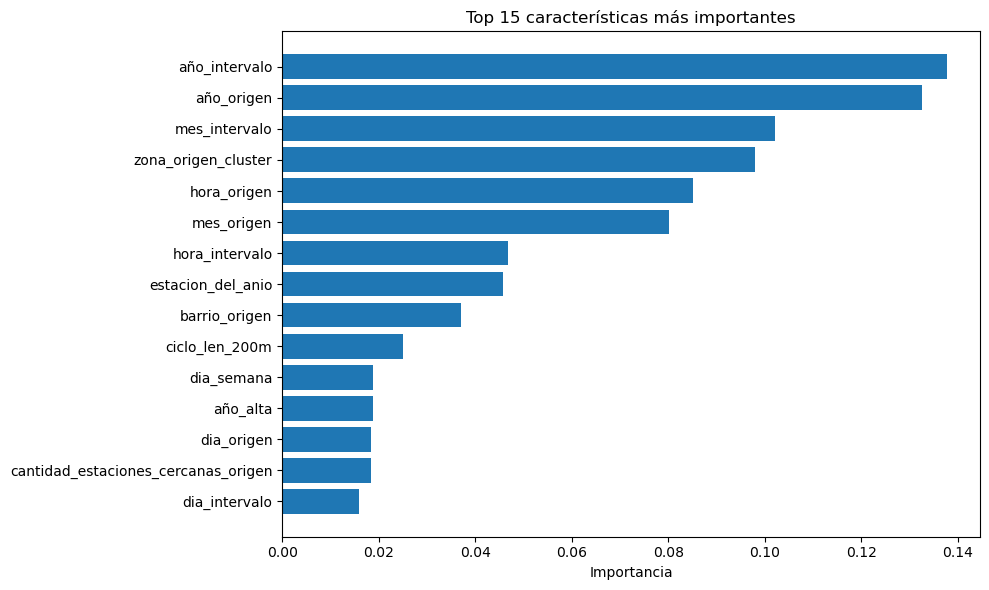

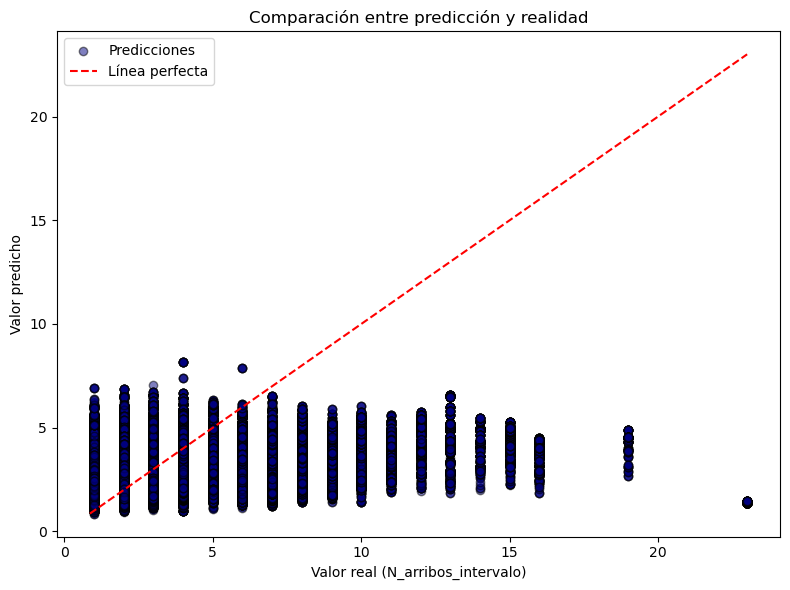

Entrenando por es_finde: 100%|██████████| 2/2 [08:04<00:00, 242.25s/it]


Ejemplos de validación:
 Real  Predicho (round)
    1          3.288952
    1          3.288952
    4          2.903152
    4          2.903152
    4          2.903152

=== XGBoost - MÉTRICAS GLOBALES ===
MAE Global: 1.9150
R² Global:  -0.0112


In [ ]:
path_dataset = "data/modelado/ds_modelado_pre.parquet"    
print("Entrenando modelo con XGBoost Poisson...")
entrenar_xgboost_por_finde(path_dataset)


=== ENTRENANDO PARA es_finde = 0 ===
  [Train] MAE: 0.4319
  [Train] R² : 0.8207
  [Val]   MAE: 0.8410
  [Val]   R² : 0.1791

🧠 El modelo está usando 47 features:
 1. id_estacion_origen
 2. zona_origen_cluster
 3. cantidad_estaciones_cercanas_origen
 4. dist_ciclovia_m
 5. ciclo_len_200m
 6. barrio_origen
 7. es_finde
 8. dia_semana
 9. hora_intervalo
10. estacion_del_anio
11. edad_usuario_anterior_1
12. edad_usuario_anterior_2
13. edad_usuario_anterior_3
14. edad_usuario_rolling7
15. usuario_registrado_anterior_1
16. usuario_registrado_anterior_2
17. usuario_registrado_anterior_3
18. usuario_registrado_rolling7
19. genero_FEMALE_anterior_1
20. genero_FEMALE_anterior_2
21. genero_FEMALE_anterior_3
22. genero_FEMALE_rolling7
23. genero_MALE_anterior_1
24. genero_MALE_anterior_2
25. genero_MALE_anterior_3
26. genero_MALE_rolling7
27. genero_OTHER_anterior_1
28. genero_OTHER_anterior_2
29. genero_OTHER_anterior_3
30. genero_OTHER_rolling7
31. modelo_bicicleta_anterior_1
32. modelo_bicicl

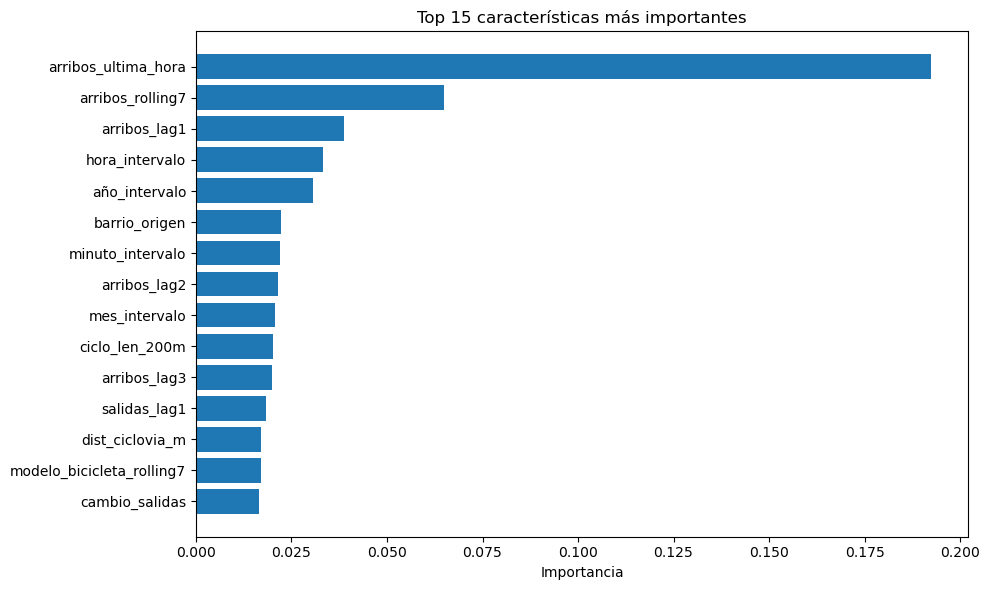

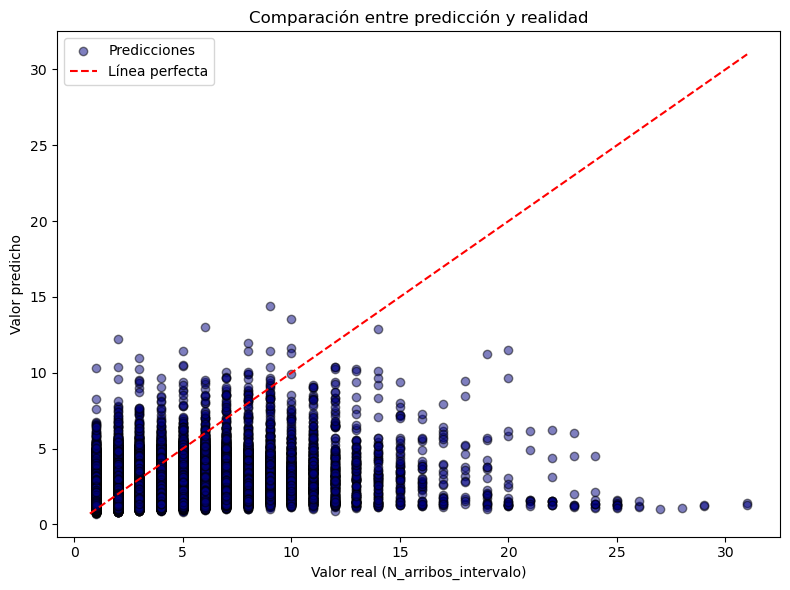


Ejemplos de validación:
 Real  Predicho (round)
    1          2.386312
    1          1.959251
    1          2.005719
    5          1.783958
   14          4.439665

=== ENTRENANDO PARA es_finde = 1 ===
  [Train] MAE: 0.1108
  [Train] R² : 0.9868
  [Val]   MAE: 0.6428
  [Val]   R² : 0.1490

🧠 El modelo está usando 47 features:
 1. id_estacion_origen
 2. zona_origen_cluster
 3. cantidad_estaciones_cercanas_origen
 4. dist_ciclovia_m
 5. ciclo_len_200m
 6. barrio_origen
 7. es_finde
 8. dia_semana
 9. hora_intervalo
10. estacion_del_anio
11. edad_usuario_anterior_1
12. edad_usuario_anterior_2
13. edad_usuario_anterior_3
14. edad_usuario_rolling7
15. usuario_registrado_anterior_1
16. usuario_registrado_anterior_2
17. usuario_registrado_anterior_3
18. usuario_registrado_rolling7
19. genero_FEMALE_anterior_1
20. genero_FEMALE_anterior_2
21. genero_FEMALE_anterior_3
22. genero_FEMALE_rolling7
23. genero_MALE_anterior_1
24. genero_MALE_anterior_2
25. genero_MALE_anterior_3
26. genero_MALE

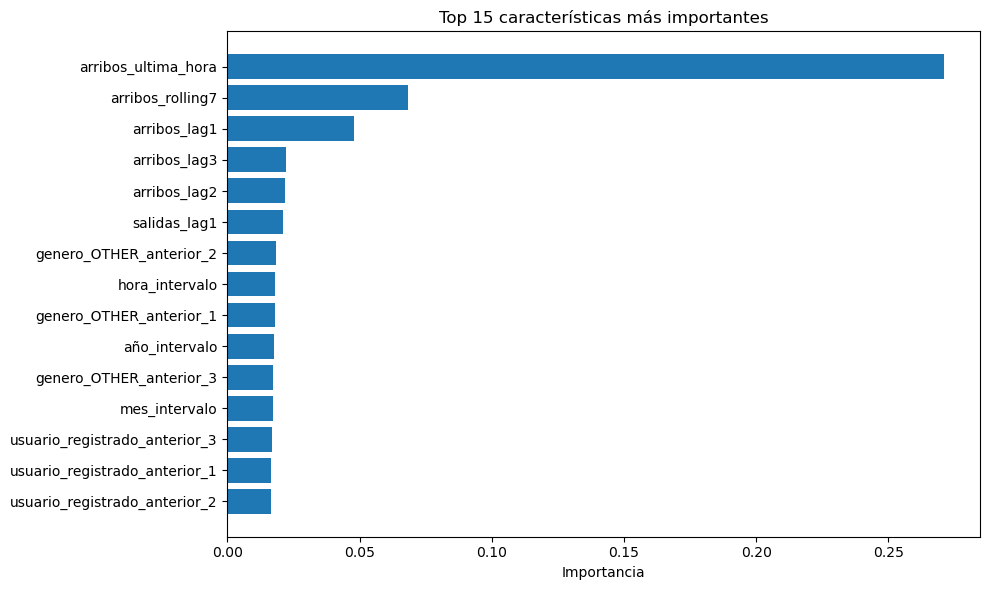

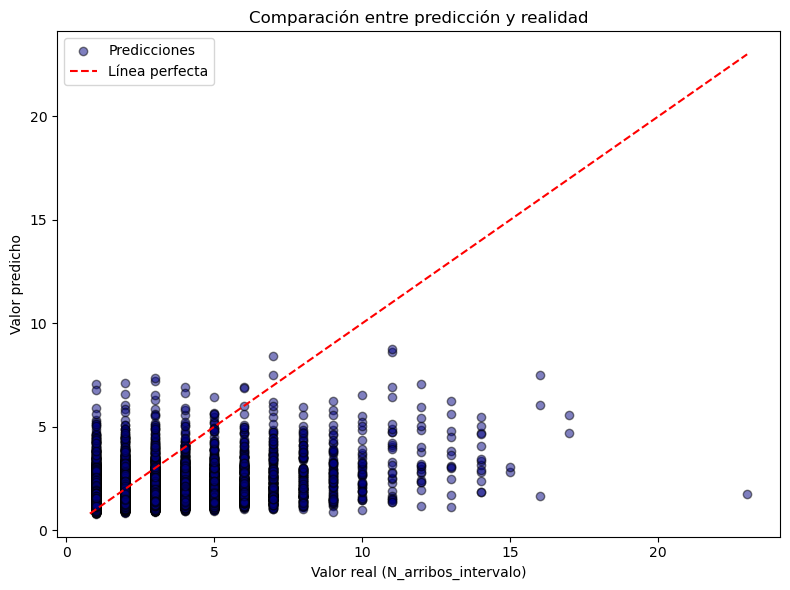


Ejemplos de validación:
 Real  Predicho (round)
    1          1.443673
    1          1.728193
    1          1.691264
    1          1.209763
    1          1.724981

=== MÉTRICAS DE VALIDACIÓN GLOBAL ===
MAE Global: 0.8174
R² Global:  0.1818
Resultados guardados en resultados_validacion.csv


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np

def entrenar_modelo_por_finde(path_modelado):
    df = pd.read_parquet(path_modelado)
    df.dropna(inplace=True)

    target = "N_arribos_intervalo"

    cols_a_excluir = [
        "N_arribos_intervalo",
        "fecha_intervalo",
        'N_salidas_intervalo',
    ]

    df_train = df[(df["año_intervalo"] < 2024) | ((df["año_intervalo"] == 2024) & (df["mes_intervalo"] <= 4))].copy()
    df_val = df[(df["año_intervalo"] == 2024) & (df["mes_intervalo"] >= 5)].copy()

    modelos = {}
    y_val_preds = pd.Series(index=df_val.index, dtype=float)

    for es_finde_val in [0, 1]:
        print(f"\n=== ENTRENANDO PARA es_finde = {es_finde_val} ===")

        df_train_sub = df_train[df_train["es_finde"] == es_finde_val]
        df_val_sub = df_val[df_val["es_finde"] == es_finde_val]

        X_train = df_train_sub.drop(columns=cols_a_excluir + [target])
        y_train = df_train_sub[target]

        X_val = df_val_sub.drop(columns=cols_a_excluir + [target])
        y_val = df_val_sub[target]

        modelo = XGBRegressor(
            n_estimators=800,
            max_depth=15,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="count:poisson",
            random_state=42,
            n_jobs=-1
        )

        modelo.fit(X_train, y_train)
        modelos[es_finde_val] = modelo

        y_train_pred = modelo.predict(X_train)
        print(f"  [Train] MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
        print(f"  [Train] R² : {r2_score(y_train, y_train_pred):.4f}")

        y_pred = modelo.predict(X_val)
        y_val_preds.loc[df_val_sub.index] = y_pred

        print(f"  [Val]   MAE: {mean_absolute_error(y_val, y_pred):.4f}")
        print(f"  [Val]   R² : {r2_score(y_val, y_pred):.4f}")

        print_features_usadas(X_train.columns)
        plot_feature_importance_bar(modelo, X_train.columns)
        plot_real_vs_pred(y_val, y_pred)

        print_ejemplos_val(y_val, y_pred)

    print("\n=== MÉTRICAS DE VALIDACIÓN GLOBAL ===")
    y_val = df_val[target]
    y_val_preds_final = y_val_preds

    mae_global = mean_absolute_error(y_val, y_val_preds_final)
    r2_global = r2_score(y_val, y_val_preds_final)

    print(f"MAE Global: {mae_global:.4f}")
    print(f"R² Global:  {r2_global:.4f}")

    df_resultado = pd.DataFrame([{
        "archivo": path_modelado,
        "mae_global": mae_global,
        "r2_global": r2_global
    }])

    ruta_resultados = "resultados_validacion.csv"
    try:
        df_existente = pd.read_csv(ruta_resultados)
        df_resultado = pd.concat([df_existente, df_resultado], ignore_index=True)
    except FileNotFoundError:
        pass 

    df_resultado.to_csv(ruta_resultados, index=False)
    print(f"Resultados guardados en {ruta_resultados}")

    return modelos, df_val, y_val, y_val_preds_final, X_train

def print_ejemplos_val(y_val, y_pred, n=5):
    print("\nEjemplos de validación:")
    ejemplos = pd.DataFrame({
        "Real": y_val.values,
        "Predicho (round)": y_pred
    }).reset_index(drop=True).head(n)
    print(ejemplos.to_string(index=False))

modelos_finde, df_val_finde, y_val_finde, y_val_preds_finde, X_train_finde = entrenar_modelo_por_finde("data/modelado/ds_modelado_group.parquet")